# E-Commerce KPI Analysis With Python And SQL
 **Made by Lucas Lopes - February 9, 2022**
<hr size="1" width="100%">

<font size="5"><strong> Definition of the business problem</strong></font><br>
<hr size="1" width="100%">

<img src='https://business.trustedshops.it/hubfs/1-TS_B2B/content/IT/20200312-coronavirus-IT/laptop-online-shopping.png'><br>
<hr size="1" width="100%">

 
<font size="3"> Our group operates in more than 20 cities, reaching tens of thousands of orders per day. One of main missions as a Catalog Team is to provide to our customers the best experience possible, making sure they see all the important information on the app and get delivered all they asked for, even not having direct contact with them!</font><br><br>
<font size="3">
    <strong>Purpose:</strong> this analysis aims to generate insights into the products and services offered by the company. Thus, we will seek answers to questions related to the pattern of consumption and sales in different stores and cities where the services are offered. We will use SQL language to query the database and Python to manipulate and generate views of the data.
</font><br><br>
<font size="2"><strong>Note:</strong> To run this experiment, unzip all zipped files and bulk the csv files into your database.</font>
<hr size="1" width="100%">


<font size="3">
    <strong>Techlology used in this experiment:</strong><br>
    <ul>
        <li>SQL Language</li><br>
        <li>Python Language</li><br>
        <li>Microsoft SQLServer 2019 (RTM) - 15.0.2000.5 (X64)</li>
    </ul>
</font>
<hr size="1" width="100%">

<font size="3">
You need install all the bellow libraries to run this jupyter Notebook.
</font>

In [1]:
# Importing the needed libraries. 

import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

<font size="3">
Function to connect on SQLServer database. It return a connection when is called.
</font><br>
<font size="2"><strong>Note:</strong> All files have been loaded into the database, the code for this is in the .sql file.</font>

In [2]:
def return_connection():
    server = "Your Server Addres here"
    database = "Your database name"
    username = "teste"
    password = "teste1234"
    string_conexao = 'Driver={SQL Server Native Client 11.0};Server=' + server + ';Database=' + database + ';UID=' + username + ';PWD=' + password
    try:
        conexao = pyodbc.connect(string_conexao, autocommit=True)
        return conexao
    except:
        return "Erro de conexão ao banco de dados!"

<hr size="1" width="100%">
<font size="4"><strong> Question 1</strong> - What's the number of orders per day of the week, distinguishing their status?</font><br>
<hr size="1" width="100%">

<font size="3"> Making the SQL query and adding the column day in the table</font><br>

In [3]:
conn = return_connection()
query = '''SELECT created_dow, order_status, COUNT(order_id) AS qtd_orders
FROM tbl_orders GROUP BY created_dow, order_status ORDER BY created_dow ASC;'''
question1 = pd.read_sql_query(query, conn)
day = {0:'Sun', 1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat'}
question1['day'] = [day[question1['created_dow'][i]] for i in question1.index]
question1.head(5)

,created_dow,order_status,qtd_orders,day
0,0,DELIVERED,975,Sun
1,0,ONGOING,583,Sun
2,0,CANCELED,73,Sun
3,1,DELIVERED,1055,Mon
4,1,ONGOING,192,Mon


<font size="3"> With the table organized and grouped by status, we'll plot a chart to visualize the first KPI.</font><br>

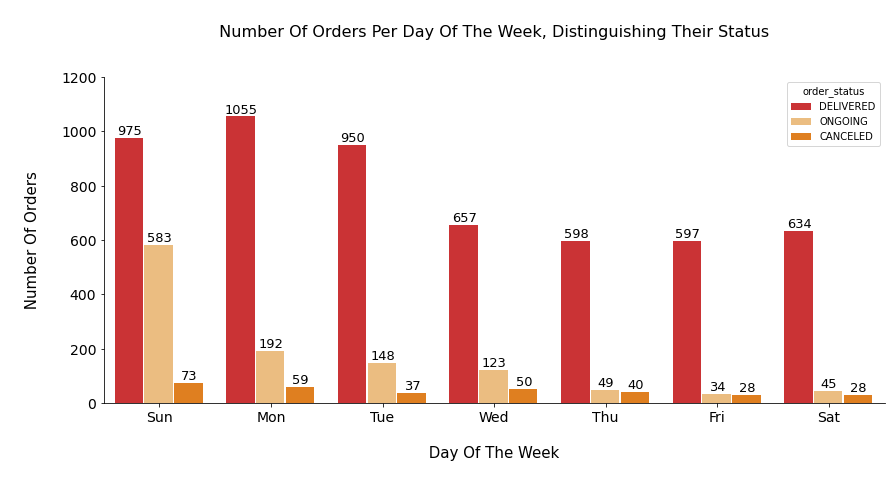

In [4]:
# Plotting the graph with the generated table

fig = plt.figure(figsize=(14,6))
ax1 = sns.barplot(data=question1, x='created_dow', y= 'qtd_orders', hue='order_status',
                  orient='v', palette=sns.color_palette("Paired")[5:8])
ax1.set_title('\n Number Of Orders Per Day Of The Week, Distinguishing Their Status \n\n', fontdict={'fontsize':16})
ax1.set_ylabel('\n Number Of Orders \n', fontdict={'fontsize':15})
ax1.set_xlabel('\n Day Of The Week \n', fontdict={'fontsize':15})
ax1.set_ylim(0, 1201)
ax1.set_xticklabels(labels=question1['day'].unique(), fontdict={'fontsize':14})
ax1.set_yticklabels(labels=range(0, 10001,200 ), fontdict={'fontsize':14})
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)  
 
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.0f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               size=13,
               xytext = (0, 7), 
               textcoords = 'offset points')
    p.set_width(0.255)

<font size="3"> With this plot, we can see that there are increase on the number of cancelation beginning by Sunday and that the delivered orders decrease from tuesday to saturday.</font><br>

<hr size="1" width="100%">
<font size="4"><strong> Question 2</strong> - What's the cancelation rate grouped by each store?</font><br>
<hr size="1" width="100%">


<font size="3"> Below, we have the SQL code to query data on database, this code combine some operations to transform the data.</font><br>

In [5]:
query = '''SELECT
d3.store,
d3.order_status,
d3.quantity,
CAST(d3.quantity AS NUMERIC(15,3)) / CAST(d3.total AS NUMERIC(15,3)) * 100.0 AS cancelation_rate
FROM (
	SELECT
	d2.store,
	d2.order_status,
	d2.quantity,
	d2.total
	FROM (
		SELECT
			d1.store,
			d1.order_status,
			d1.quantity,
			CAST(SUM(d1.quantity) OVER() AS NUMERIC(15,3)) total
			FROM (
				SELECT
					d.store,
					d.order_status,
					COUNT(d.order_status) AS quantity
						FROM (
						SELECT store, order_id, order_status FROM tbl_orders
						INNER JOIN tbl_store_branch ON tbl_store_branch.storebranch_id = tbl_orders.storebranch_id
						) d GROUP BY d.store, d.order_status) d1)d2 WHERE d2.order_status = 'CANCELED') d3 ORDER BY d3.store;'''

question2 = pd.read_sql_query(query, conn)
question2 = question2.sort_values(by='cancelation_rate', ascending=False)
question2.head()

,store,order_status,quantity,cancelation_rate
4,c0b93cf93cf854981b8d6bd849eec4b0,CANCELED,151,2.171100
1,452ae015bf846e1d2932b7ea15720d64,CANCELED,87,1.250899
0,044d56734d20e04984d846dade6d39f3,CANCELED,30,0.431344
2,6447951cd071f6f045fd4e6194920926,CANCELED,24,0.345075
5,e27789d5e619b255663b2bfa68b5851f,CANCELED,17,0.244428


<font size="3"> With the created table, we need to plot a chart to view the cancelation rate grouped by each store.</font><br>

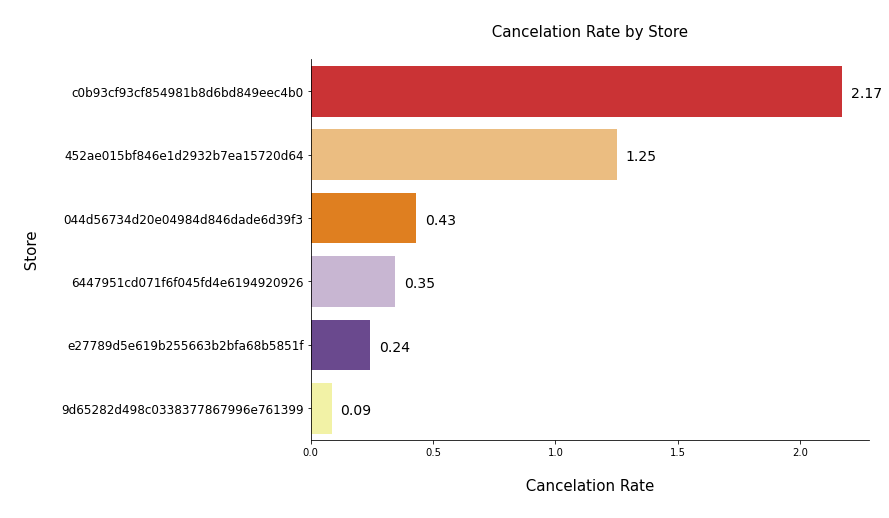

In [6]:
# Setting data and parameters to create a graph

p1, ax1 = plt.subplots(figsize=(10, 7))
ax1 = sns.barplot(x=question2['cancelation_rate'], y=question2['store'], orient='h', palette=sns.color_palette("Paired")[5:])
ax1.set_title('\n Cancelation Rate by Store \n', fontdict={'fontsize':15})
ax1.set_ylabel('\n Store \n', fontdict={'fontsize':15})
ax1.set_xlabel('\n Cancelation Rate \n', fontdict={'fontsize':15})
ax1.set_yticklabels(labels =question2['store'], fontdict={'fontsize':12})
ax1.set_xlim()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# plotting the data labels of  the bar chart
for p in ax1.patches:
    _x = p.get_x() + p.get_width() + 0.099
    _y = p.get_y() + p.get_height() -0.3
    value = str(round(p.get_width(), 2))
    ax1.text(_x, _y, value, fontdict={'color':'black', 'fontsize':14},
              horizontalalignment='center')



<font size="3"> With the chart above we can see that the mains cancelation rate is on the stores:<br><br> 1) c0b93cf93cf854981b8d6bd849eec4b0<br> 2) 452ae015bf846e1d2932b7ea15720d64</font><br>

<hr size="1" width="100%">
<font size="4"><strong> Question 3</strong> - What's the average found rate(*) of the orders grouped by store and city?</font><br>

<font size="2"><strong>Found Rate:</strong> ratio between the amount of product ids the customer requested (regardless of how much of each product was requested) and the quantity of product ids the shopper found (again, regardless of the how much of each product was found)</font><br>
<hr size="1" width="100%">

<font size="3"> Making the query on database</font><br>

In [7]:
query = '''SELECT
	d2.store,
	d2.city,
	d2.found,
	ROUND(CAST(d2.times_found AS NUMERIC(15,2)) / CAST(SUM(d2.times_found) 
	OVER() AS NUMERIC (15,2)), 2) avg_found_rate
FROM(
	SELECT
			d1.store,
			d1.city,
			d1.found,
			COUNT(d1.found) times_found
	FROM(
			SELECT
			d.order_id,
			d.store,
			d.city,
			d.product_id,
			d.quantity_found,

			CASE
				WHEN d.quantity_found > 0 THEN 'yes'
				ELSE 'no'
			END found
				FROM (
					SELECT tbl_orders.order_id, store, city, product_id, quantity_found FROM tbl_orders
					INNER JOIN tbl_store_branch ON tbl_orders.storebranch_id = tbl_store_branch.storebranch_id 
					INNER JOIN tbl_orders_product ON tbl_orders_product.order_id = tbl_orders.order_id)
					d) d1 GROUP BY d1.store, d1.city,d1.found) d2;'''

question3 = pd.read_sql_query(query, conn)
question3.head()

,store,city,found,avg_found_rate
0,044d56734d20e04984d846dade6d39f3,124a5007acdbf3654148e290aec94206,no,0.00
1,044d56734d20e04984d846dade6d39f3,124a5007acdbf3654148e290aec94206,yes,0.01
2,044d56734d20e04984d846dade6d39f3,32282234445dfe3c5b80c62656f0e9bf,no,0.01
3,044d56734d20e04984d846dade6d39f3,32282234445dfe3c5b80c62656f0e9bf,yes,0.03
4,044d56734d20e04984d846dade6d39f3,992afbe416daf0b89120bdfd78b64c53,no,0.01


<font size="3"> Here we will assign generic names to the stores and to the products, this will facilitate the visualization of the data.</font><br>

In [8]:
store = question3['store'].unique()
city = question3['city'].unique()

In [9]:
store

array(['044d56734d20e04984d846dade6d39f3',
       '452ae015bf846e1d2932b7ea15720d64',
       '6447951cd071f6f045fd4e6194920926',
       '9d65282d498c0338377867996e761399',
       'c0b93cf93cf854981b8d6bd849eec4b0',
       'e27789d5e619b255663b2bfa68b5851f'], dtype=object)

In [10]:
city

array(['124a5007acdbf3654148e290aec94206',
       '32282234445dfe3c5b80c62656f0e9bf',
       '992afbe416daf0b89120bdfd78b64c53',
       '9b34c2119d40a8aaf639f44728a459ba',
       '9b965979c8601c64f30b02d07036cf7a',
       'b5f1a1890fb0b1db5f744a109a40a437'], dtype=object)

In [11]:
store_dict = {
       '044d56734d20e04984d846dade6d39f3':'Store 1',
       '452ae015bf846e1d2932b7ea15720d64':'Store 2',
       '6447951cd071f6f045fd4e6194920926':'Store 3',
       '9d65282d498c0338377867996e761399':'Store 4',
       'c0b93cf93cf854981b8d6bd849eec4b0':'Store 5',
       'e27789d5e619b255663b2bfa68b5851f':'Store 6'
}

city_dict = {
       '124a5007acdbf3654148e290aec94206':'A',
       '32282234445dfe3c5b80c62656f0e9bf':'B',
       '992afbe416daf0b89120bdfd78b64c53':'C',
       '9b34c2119d40a8aaf639f44728a459ba':'D',
       '9b965979c8601c64f30b02d07036cf7a':'E',
       'b5f1a1890fb0b1db5f744a109a40a437':'F'
}

question3['number_store'] = [store_dict[question3['store'][i]] for i in question3.index]
question3['letter_city'] = [city_dict[question3['city'][i]] for i in question3.index]
question3.head()

,store,city,found,avg_found_rate,number_store,letter_city
0,044d56734d20e04984d846dade6d39f3,124a5007acdbf3654148e290aec94206,no,0.00,Store 1,A
1,044d56734d20e04984d846dade6d39f3,124a5007acdbf3654148e290aec94206,yes,0.01,Store 1,A
2,044d56734d20e04984d846dade6d39f3,32282234445dfe3c5b80c62656f0e9bf,no,0.01,Store 1,B
3,044d56734d20e04984d846dade6d39f3,32282234445dfe3c5b80c62656f0e9bf,yes,0.03,Store 1,B
4,044d56734d20e04984d846dade6d39f3,992afbe416daf0b89120bdfd78b64c53,no,0.01,Store 1,C


<font size="3">
    Now we have generic names for each store and product id.<br><br>
    We are ready to plot the graph with the average found rate of the orders grouped by store and city
</font><br>


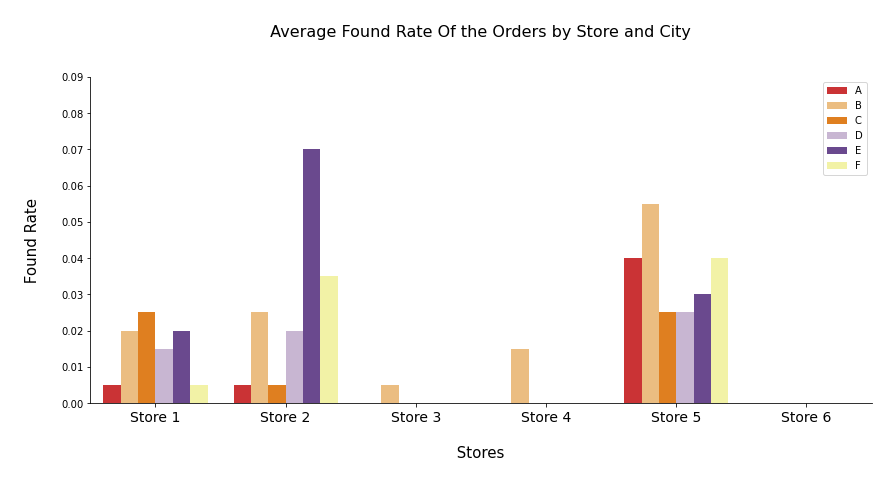

In [12]:
# Plotting the graph with the generated table

sns.color_palette("hls", 8)   
fig = plt.figure(figsize=(14,6))
ax1 = sns.barplot(data=question3, x='number_store', y= 'avg_found_rate', hue='letter_city', ci=None, orient='v', palette=sns.color_palette("Paired")[5:])
ax1.set_title('\n Average Found Rate Of the Orders by Store and City \n\n', fontdict={'fontsize':16})
ax1.set_ylabel('\n Found Rate \n', fontdict={'fontsize':15})
ax1.set_xlabel('\n Stores \n', fontdict={'fontsize':15})
ax1.set_ylim(0, 0.09)
ax1.set_xticklabels(labels=question3['number_store'].unique(), fontdict={'fontsize':14})
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)  
ax1.legend()

<font size="3">
    The graph above shows a situation that appears to be worrying, suggesting that customers are not finding products as per their requests in stores 3, 4 and 6.<br>
</font>


<hr size="1" width="100%">
<font size="4"><strong> Question 4</strong> - What's the top 3 selling products ids in total volume delivered to customer?</font>
<hr size="1" width="100%">


<font size="3">
    Querying the database <br>
</font>

In [13]:
query = '''SELECT TOP 3 product_id, SUM(CAST(quantity AS FLOAT)) AS total_quantity 
FROM tbl_orders_product 
GROUP BY product_id 
ORDER BY total_quantity DESC;'''

question4 = pd.read_sql_query(query, conn)
question4.head()

,product_id,total_quantity
0,928ed632b4c042e0dd6566f11b69aed3,2879.0
1,7fe7035d71c3eeefed9d5e6ffe9351f8,2016.0
2,298a9cc86e93881c4193e9e03cbbeb7b,1877.0


<font size="3">
    We will assign generic names to the products again<br>
</font>

In [14]:
question4 = pd.DataFrame(data = {'product_id':question4['product_id'].unique(),
                           'product_name':['Product A','Product B','Product C'],
                           'total_quantity':question4['total_quantity']})
question4

,product_id,product_name,total_quantity
0,928ed632b4c042e0dd6566f11b69aed3,Product A,2879.0
1,7fe7035d71c3eeefed9d5e6ffe9351f8,Product B,2016.0
2,298a9cc86e93881c4193e9e03cbbeb7b,Product C,1877.0


<font size="3">
    Now, we can plot the top 3 selling products<br>
</font>

No handles with labels found to put in legend.


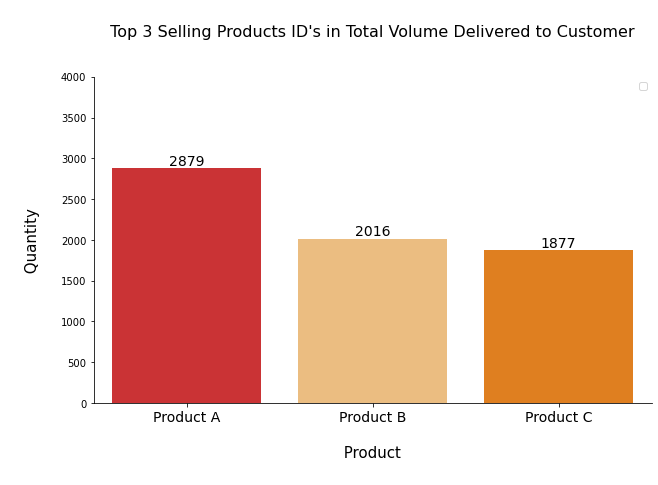

In [15]:
# Plotting the graph with the generated table
sns.color_palette("hls", 8)   
fig = plt.figure(figsize=(10,6))
ax1 = sns.barplot(data=question4, x='product_name', y= 'total_quantity', ci=None, orient='v', palette=sns.color_palette("Paired")[5:])
ax1.set_title("\n Top 3 Selling Products ID's in Total Volume Delivered to Customer \n\n", fontdict={'fontsize':16})
ax1.set_ylabel('\n Quantity \n', fontdict={'fontsize':15})
ax1.set_xlabel('\n Product \n', fontdict={'fontsize':15})
ax1.set_ylim(0, 4001)
ax1.set_xticklabels(labels=question4['product_name'], fontdict={'fontsize':14})
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)  
ax1.legend()

for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.0f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               size=14,
               xytext = (0, 7), 
               textcoords = 'offset points')


<font size="3">
   These products certainly represent a large portion of the company's revenue, so sales actions must be directed to maintain the Top 3 selling.
    <br>
</font>


<hr size="1" width="100%">
<font size="4"><strong> Question 5</strong> - What's the % of delivered orders that were created and delivered in different days, grouped by hour of creation.</font>
<hr size="1" width="100%">

<font size="3">
    Querying the database <br>
</font>

In [16]:
query = '''SELECT
d3.same_day,
d3.created_hour,
d3.qtd,
d3.total,
(CAST(d3.qtd AS NUMERIC (15, 3)) / CAST(d3.total AS NUMERIC (15, 3))) * 100.0 AS perc
FROM (
	SELECT
		d2.same_day,
		d2.created_hour,
		d2.qtd,
		SUM(d2.qtd) OVER() AS total
	FROM (
		SELECT
		d1.same_day,
		d1.created_hour,
		COUNT(d1.same_day) AS qtd
		FROM(
			SELECT
			d.order_id,
			d.created_time,
			d.created_dow,
			d.delivered_dow,
			LEFT(d.created_time, 2) AS created_hour,
			CASE
				WHEN d.created_dow <> d.delivered_dow THEN 'yes'
				ELSE 'no'
			END same_day
				FROM(
				SELECT order_id, created_time, created_dow, delivered_dow
				FROM tbl_orders WHERE order_status = 'DELIVERED') d) d1 GROUP BY d1.same_day, d1.created_hour)d2 )d3;'''

question5 = pd.read_sql_query(query, conn)
question5.head()

,same_day,created_hour,qtd,total,perc
0,no,00,68,5466,1.244054
1,yes,00,2,5466,0.036590
2,no,01,27,5466,0.493963
3,yes,01,3,5466,0.054885
4,no,02,20,5466,0.365898


<font size="3">
    Here we have the percent for two categories on column "same day", yes or no for delivered at same day. <br><br>
</font>

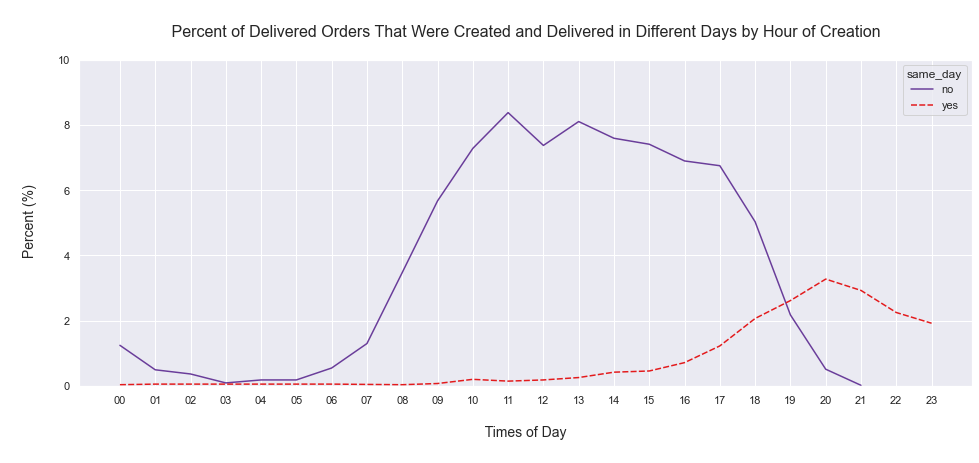

In [17]:
# Plotting the graph with the generated table

cs = [sns.color_palette("Paired")[9], sns.color_palette("Paired")[5]]
sns.set_theme()
fontdict={'fontsize':14}
plt.figure(figsize=(16,6))
ax = sns.lineplot(data = question5, x = 'created_hour', y = 'perc', hue='same_day', style='same_day', palette=cs )
ax.set_title('\n Percent of Delivered Orders That Were Created and Delivered in Different Days by Hour of Creation \n',
             fontdict={'fontsize':16})
ax.set_ylim(0, 10)
ax.set_xlabel('\n Times of Day \n', fontdict=fontdict)
ax.set_ylabel('\n Percent (%)\n', fontdict=fontdict)
plt.show()

<font size="3">
    We can see that the later orders are placed, the more likely they are to be delivered on another day. <br><br>
</font>


<hr size="1" width="100%">
<font size="4"><strong> Question 6</strong> - How many products there are in each partition of the ABC Sales Curve grouped by store.</font>
<hr size="1" width="100%">

<font size="3">
    Querying the database <br>
</font>

In [18]:
query = '''SELECT d3.store,
	   d3.class_abc,
	   COUNT(d3.class_abc) AS quantity_abc
FROM (
SELECT d2.store,
	   d2.product_id,
	   d2.total_billing,
	   d2.grand_total,
	   d2.perc,
	   d2.acc_perc,
	   CASE
			WHEN d2.acc_perc <= 80 THEN 'A'
			WHEN d2.acc_perc <= 95 THEN 'B'
			ELSE 'C'
		END class_abc
FROM (
SELECT d1.store,
	   d1.product_id,
	   d1.total_billing,
	   d1.grand_total,
	   d1.perc,
	   SUM(d1.perc) OVER(ORDER BY d1.total_billing DESC) acc_perc

FROM (
SELECT d.store,
	d.product_id,
	d.total_billing,
	SUM(d.total_billing) OVER() grand_total,
	CAST(d.total_billing AS NUMERIC(15,3)) / CAST(SUM(d.total_billing) OVER() AS NUMERIC(15,3)) * 100 perc
		FROM (
			SELECT store, product_id, SUM(CAST(quantity AS FLOAT))* sum(unit_price) AS total_billing FROM tbl_orders
			INNER JOIN tbl_store_branch ON tbl_orders.storebranch_id = tbl_store_branch.storebranch_id 
			INNER JOIN tbl_orders_product ON tbl_orders_product.order_id = tbl_orders.order_id
			GROUP BY store, product_id) d) d1) d2)d3 group by  d3.store, d3.class_abc ORDER BY d3.store, d3.class_abc;'''

question6 = pd.read_sql_query(query, conn)
question6.head()

,store,class_abc,quantity_abc
0,044d56734d20e04984d846dade6d39f3,A,225
1,044d56734d20e04984d846dade6d39f3,B,673
2,044d56734d20e04984d846dade6d39f3,C,2050
3,452ae015bf846e1d2932b7ea15720d64,A,234
4,452ae015bf846e1d2932b7ea15720d64,B,719


<font size="3">
    In this table we have the amount of products existing in each interval of the ABC curve grouped by store.  <br>
</font>

In [19]:
question6['store'].unique()

array(['044d56734d20e04984d846dade6d39f3',
       '452ae015bf846e1d2932b7ea15720d64',
       '6447951cd071f6f045fd4e6194920926',
       '9d65282d498c0338377867996e761399',
       'c0b93cf93cf854981b8d6bd849eec4b0',
       'e27789d5e619b255663b2bfa68b5851f'], dtype=object)

<font size="3">
    We will assign generic names to the products again<br>
</font>

In [20]:
store_dict = {
       '044d56734d20e04984d846dade6d39f3':'Store 1',
       '452ae015bf846e1d2932b7ea15720d64':'Store 2',
       '6447951cd071f6f045fd4e6194920926':'Store 3',
       '9d65282d498c0338377867996e761399':'Store 4',
       'c0b93cf93cf854981b8d6bd849eec4b0':'Store 5',
       'e27789d5e619b255663b2bfa68b5851f':'Store 6'
}

question6['number_store'] = [store_dict[question6['store'][i]] for i in question6.index]
question6.head()

,store,class_abc,quantity_abc,number_store
0,044d56734d20e04984d846dade6d39f3,A,225,Store 1
1,044d56734d20e04984d846dade6d39f3,B,673,Store 1
2,044d56734d20e04984d846dade6d39f3,C,2050,Store 1
3,452ae015bf846e1d2932b7ea15720d64,A,234,Store 2
4,452ae015bf846e1d2932b7ea15720d64,B,719,Store 2


<font size="3">
    Now, we can plot the result of the ABC Analysis.<br>
</font>


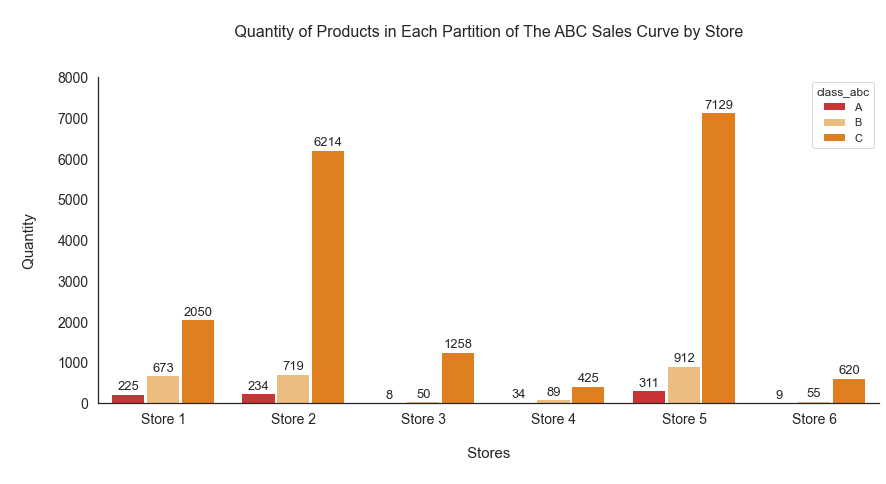

In [21]:
# Plotting the graph with the generated table
sns.set_theme(style="white")  
fig = plt.figure(figsize=(14,6))
ax1 = sns.barplot(data=question6, x='number_store', y= 'quantity_abc', hue='class_abc', orient='v', palette=sns.color_palette("Paired")[5:8])
ax1.set_title('\n Quantity of Products in Each Partition of The ABC Sales Curve by Store \n\n', fontdict={'fontsize':16})
ax1.set_ylabel('\n Quantity \n', fontdict={'fontsize':15})
ax1.set_xlabel('\n Stores \n', fontdict={'fontsize':15})
ax1.set_ylim(0, 8001)
ax1.set_xticklabels(labels=question6['number_store'].unique(), fontdict={'fontsize':14})
ax1.set_yticklabels(labels=range(0, 8001, 1000), fontdict={'fontsize':14})
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)  
 
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.0f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               size=13,
               xytext = (0, 7), 
               textcoords = 'offset points')
    p.set_width(0.255)

<font size="3">
    Looking at the graph, we can easily identify the Pareto principle, in which 80% of the effects are due to 20% of the causes. We can see that category A of products has a lower quantity than all the others, but is responsible for about 80% of the revenue.
    <br>
</font>


<hr size="1" width="100%">
<font size="4"><strong> Question 7</strong> - What's the % of delivered orders in which the picker_id and driver_id are different?</font>
<hr size="1" width="100%">

<font size="3">
    Querying the database <br>
</font>

In [22]:
query = '''SELECT
	d2.class,
	d2.quantity,
	ROUND(CAST(d2.quantity AS NUMERIC(15,2)) / CAST(SUM(d2.quantity) OVER() AS NUMERIC (15,2))*100, 2) percent_
		FROM (

		SELECT
		d1.class,
		COUNT(d1.class) quantity
			FROM (

			SELECT
			d.order_id,
			CASE
				WHEN d.picker_id <> d.driver_id THEN 'different'
				ELSE 'equal'
			END class

				FROM (
				SELECT tbl_orders.picker_id, tbl_orders.driver_id, tbl_orders.order_id
				FROM tbl_orders
				) d) d1 GROUP BY d1.class) d2;'''

question7 = pd.read_sql_query(query, conn)
question7.head()

,class,quantity,percent_
0,different,2,0.03
1,equal,6953,99.97


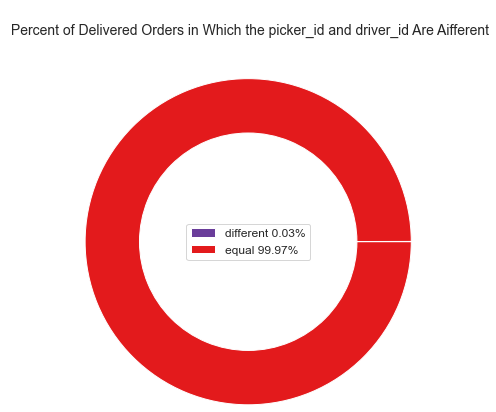

In [23]:
# Plot

labels = [str(question7['class'][line]) + ' ' + str(round(question7['percent_'][line], 2)) + '%' for line in question7.index]

cs = [sns.color_palette("Paired")[9], sns.color_palette("Paired")[5]]
f = plt.figure(figsize=(2.5, 2.5))

# Pie Plot
plt.pie(question7['quantity'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 1))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("\n Percent of Delivered Orders in Which the picker_id and driver_id Are Different",
          pad=140, fontdict = {'fontsize':14,'fontweight':20})
plt.show()

<font size="3">
    As the graph above shows, only about 0.03% of sales have different picker_id and driver_id.<br>
</font>
<hr size="1" width="100%">

<font size="5">
    <strong>Main conclusions about the KPI's:</strong><br><br>
</font>
<hr size="1" width="100%">
<font size="3">

<ol>
<li>It is necessary to investigate further why the cancellation fees are higher at the beginning of the week.<br><br>
    <ol>
    <li>Is there any relationship with the waiting time?</li><br>
    <li>Is there any relationship with the number of requests?</li><br>
    </ol>
</li>
<li>The cancellation rate per store suggests that there are differences between stores.<br><br>
 <ol>
   <li>Could these differences be in product quality or delivery time?</li><br>
 </ol>
</li>
    
<li>The average rate of requests and products found also suggests that it is necessary to investigate the causes of the difference in performance between stores.<br><br>
    <ol>
        <li>Why do some stores have such a low found rate?</li><br>
        <li>Are these stores being stocked at the correct frequency?</li><br>
        <li>Is the store's product catalog being updated on time?</li><br>
    </ol>
</li>
<li>These products certainly represent a large portion of the company's revenue, so sales actions must be directed to maintain the Top 3 selling. In this context, it makes sense to investigate some points such as:<br><br>
    <ol>
        <li>Why are these products the best sellers?</li><br>
        <li>What is your price range?</li><br>
        <li>How is the found rate for these products?</li><br>
        <li>On which days are these products most sold?</li><br>
    </ol>
</li>
<li>We can see that the later orders are placed, the more likely they are to be delivered on another day.<br><br>
    <ol>
        <li>What would be the percentage of orders created and delivered on the same day per store?</li><br>
    </ol>
</li>
<li>What are the products contained in partition A of ABC analysis?<br><br>
    <ol>
    <li>How are these products being made available?</li><br>
    <li>Are there active marketing campaigns to strengthen the image of these products?</li><br>
</ol>
</li>
<li>Practically 99.9% of the establishments that make requests are the same ones that deliver.</li><br>
</ol>
</font>


<hr size="1" width="100%">
<font size="6">
    <strong> Thank you!</strong><br><br>
</font>
<font size="2">
    If you have any doubts, you can contact me by email: <a src='<hr size="50" width="100%">'>lucasflopes012@gmail.com<a><br><br>
</font>
<hr size="1" width="100%">